In [23]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
df = pd.read_excel("INPUT SET 1.xlsx")

In [25]:
# splitting the remaining data in training data and validation data. 
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, shuffle = False)

In [26]:
df_train.index = range(df_train.shape[0])
df_test.index = range(df_test.shape[0])

In [27]:
# Scaling the data using MinMax Scaler.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_train.drop(["Month4"],axis=1).values)
Y_train = scaler.fit_transform(df_train["Month4"].values.reshape(-1,1))
X_test = scaler.fit_transform(df_test.drop(["Month4"],axis=1).values)
Y_test = scaler.fit_transform(df_test["Month4"].values.reshape(-1,1))

In [28]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(963, 3)
(963, 1)
(414, 3)
(414, 1)


In [29]:
# function to denormalise the predicted values.
def denormalize(df,norm_data):
    df = df["Month4"].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    
    return new

In [30]:
# Reshaping the data into [samples, test_size, n_features] suitable for LSTM model.
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
#-----------------------------------------------------------------------------------------------------
# Definition for LSTM using tensorflow.

In [39]:
# defining hyper parameters for LSTM model.
epochs = 50
n_hidden = 50
n_features = 3
batch_size = 100
train_loss = []

In [40]:
# to reset tensorflow graph for every run.
tf.reset_default_graph()

In [41]:
# variables required for model creation.
x_data = tf.placeholder('float',[None,n_features,1])
y_target = tf.placeholder('float')

W = tf.Variable(tf.random_normal([n_hidden, 1]))
bias = tf.Variable(tf.random_normal([1]))

# 1-layer LSTM with n_hidden units.  
rnn_cell = rnn.BasicLSTMCell(n_hidden)

In [42]:
def rnn_model(x):

    # Generate a n_input-element sequence of inputs
    # (eg. [had] [a] [general] -> [20] [6] [33])
    x = tf.unstack(x, n_features, 1)

    # generate prediction
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # there are n_features outputs but
    # we only want the last output
    return (tf.matmul(outputs[-1], W) + bias)

In [43]:
# output equation of LSTM model.
y_predicted = tf.reshape(rnn_model(x_data),[-1])

In [44]:
# loss function = MSE (Mean Squared Error)
cost = tf.reduce_mean(tf.square(y_predicted-y_target))

In [45]:
# Using Adam as the optimization algorithm.
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)
#tf.train.GradientDescentOptimizer(0.01).minimize(cost)

In [46]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [50]:
for epoch in range(epochs):
    
        start = random.randint(0,(len(X_train)-batch_size))
        end = start + batch_size

        batch_x = np.array(X_train[start:end])
        batch_y = np.array(Y_train[start:end])
        
        # loop for training each batch.    
        for j in range(batch_x.shape[0]): 
            sess.run(optimizer, feed_dict={x_data: batch_x[j].reshape(1,3,1) , y_target: batch_y[j]})
        #loop for training each batch ends.       
            
        train_loss.append(sess.run(cost, feed_dict={x_data:X_train,y_target:Y_train}))
        
        print('Epoch', epoch, 'completed out of', epochs, 'Training_loss:', train_loss[epoch])

Epoch 0 completed out of 50 Training_loss: 0.057345532
Epoch 1 completed out of 50 Training_loss: 0.055766728
Epoch 2 completed out of 50 Training_loss: 0.05253648
Epoch 3 completed out of 50 Training_loss: 0.048543997
Epoch 4 completed out of 50 Training_loss: 0.053596657
Epoch 5 completed out of 50 Training_loss: 0.053137213
Epoch 6 completed out of 50 Training_loss: 0.04567958
Epoch 7 completed out of 50 Training_loss: 0.06545007
Epoch 8 completed out of 50 Training_loss: 0.04877084
Epoch 9 completed out of 50 Training_loss: 0.054563563
Epoch 10 completed out of 50 Training_loss: 0.048947103
Epoch 11 completed out of 50 Training_loss: 0.05423791
Epoch 12 completed out of 50 Training_loss: 0.060166955
Epoch 13 completed out of 50 Training_loss: 0.061104883
Epoch 14 completed out of 50 Training_loss: 0.068291515
Epoch 15 completed out of 50 Training_loss: 0.05139385
Epoch 16 completed out of 50 Training_loss: 0.0591264
Epoch 17 completed out of 50 Training_loss: 0.05153206
Epoch 18 co

In [51]:
# stores the predicted value for test data.
pred = sess.run(y_predicted, feed_dict={x_data:X_test})

In [52]:
# denormalizing our predicted value.
y_test = denormalize(df_test, Y_test)
pred = denormalize(df_test, pred)

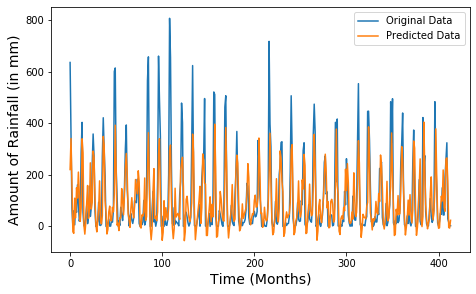

In [53]:
# plot showing difference between actual test data and predicted test data.
plt.figure(figsize=[5*1.5,3*1.5])
plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
plt.plot(range(y_test.shape[0]),pred,label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('Amount of Rainfall (in mm)', fontsize="14")
plt.xlabel('Time (Months)', fontsize="14")
plt.show()

In [54]:
print("MAE : ", np.mean(abs(y_test-pred)))

MAE :  72.45668283447552


In [55]:
print("RMSE : ", np.sqrt(np.mean(np.square(y_test-pred))))

RMSE :  111.19018008873094


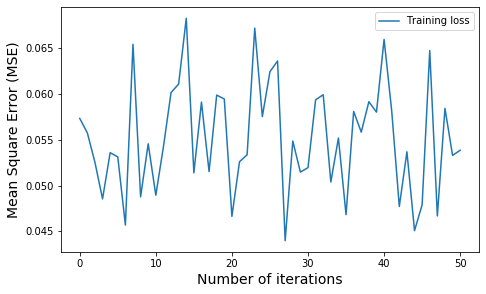

In [56]:
plt.figure(figsize=[5*1.5,3*1.5])
plt.plot(range(len(train_loss)),train_loss,label="Training loss")
plt.legend(loc='best')
plt.ylabel('Mean Square Error (MSE)', fontsize="14")
plt.xlabel('Number of iterations',fontsize="14")
plt.show()